In [8]:
# 1. Import Required Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm  


Cell 1 Imports necessary Libraries for data handling,visualization and deep learning.

In [9]:
# 2. Load the Dataset (Optimized)
dataset_path = r'C:\Users\suraa\Downloads\UTKFace'
subfolders = ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']

data = []
for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        for file in tqdm(files, desc=f'Processing {folder}'):
            try:
                parts = file.split('_')
                if len(parts) >= 2:
                    img_path = os.path.join(folder_path, file)
                    gender = int(parts[1])  # 0=male, 1=female
                    age = int(parts[0])
                    data.append((img_path, gender, age))
            except:
                continue

df = pd.DataFrame(data, columns=['image_path', 'gender', 'age'])
print(f"\nLoaded metadata for {len(df)} images")


Processing UTKFace: 100%|██████████| 23708/23708 [00:00<00:00, 240015.83it/s]
Processing utkface_aligned_cropped: 0it [00:00, ?it/s]



Loaded metadata for 33488 images


cell 2 :
Dataset: The UTKFace dataset containing 33,488 images was loaded from multiple subfolders

In [10]:
# 3. Data Pre-Processing & Feature Selection
# ▪ Data Cleaning
df = df[df['gender'].isin([0, 1])]

# ▪ Filling Missing Values
if df['age'].isnull().any():
    df['age'] = df['age'].fillna(df['age'].median())

# ▪ Noisy Data
def is_valid_image(path):
    try:
        img = cv2.imread(path)
        return img is not None
    except:
        return False

df = df[df['image_path'].apply(is_valid_image)]

# ▪ Removal of Outliers
df = df[df['age'].between(15, 70)]

# ▪ Transforming Categorical Variables
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 45, 60, 100],
                        labels=['0-18', '19-30', '31-45', '46-60', '60+']
                        ).astype(str)

Cell 3: Data Cleaning:

Filtered to only include valid gender labels (0=male, 1=female)

Removed corrupted images using is_valid_image() function

Eliminated age outliers (kept only ages 15-70)

Feature Engineering:

Created age groups for better visualization and analysis

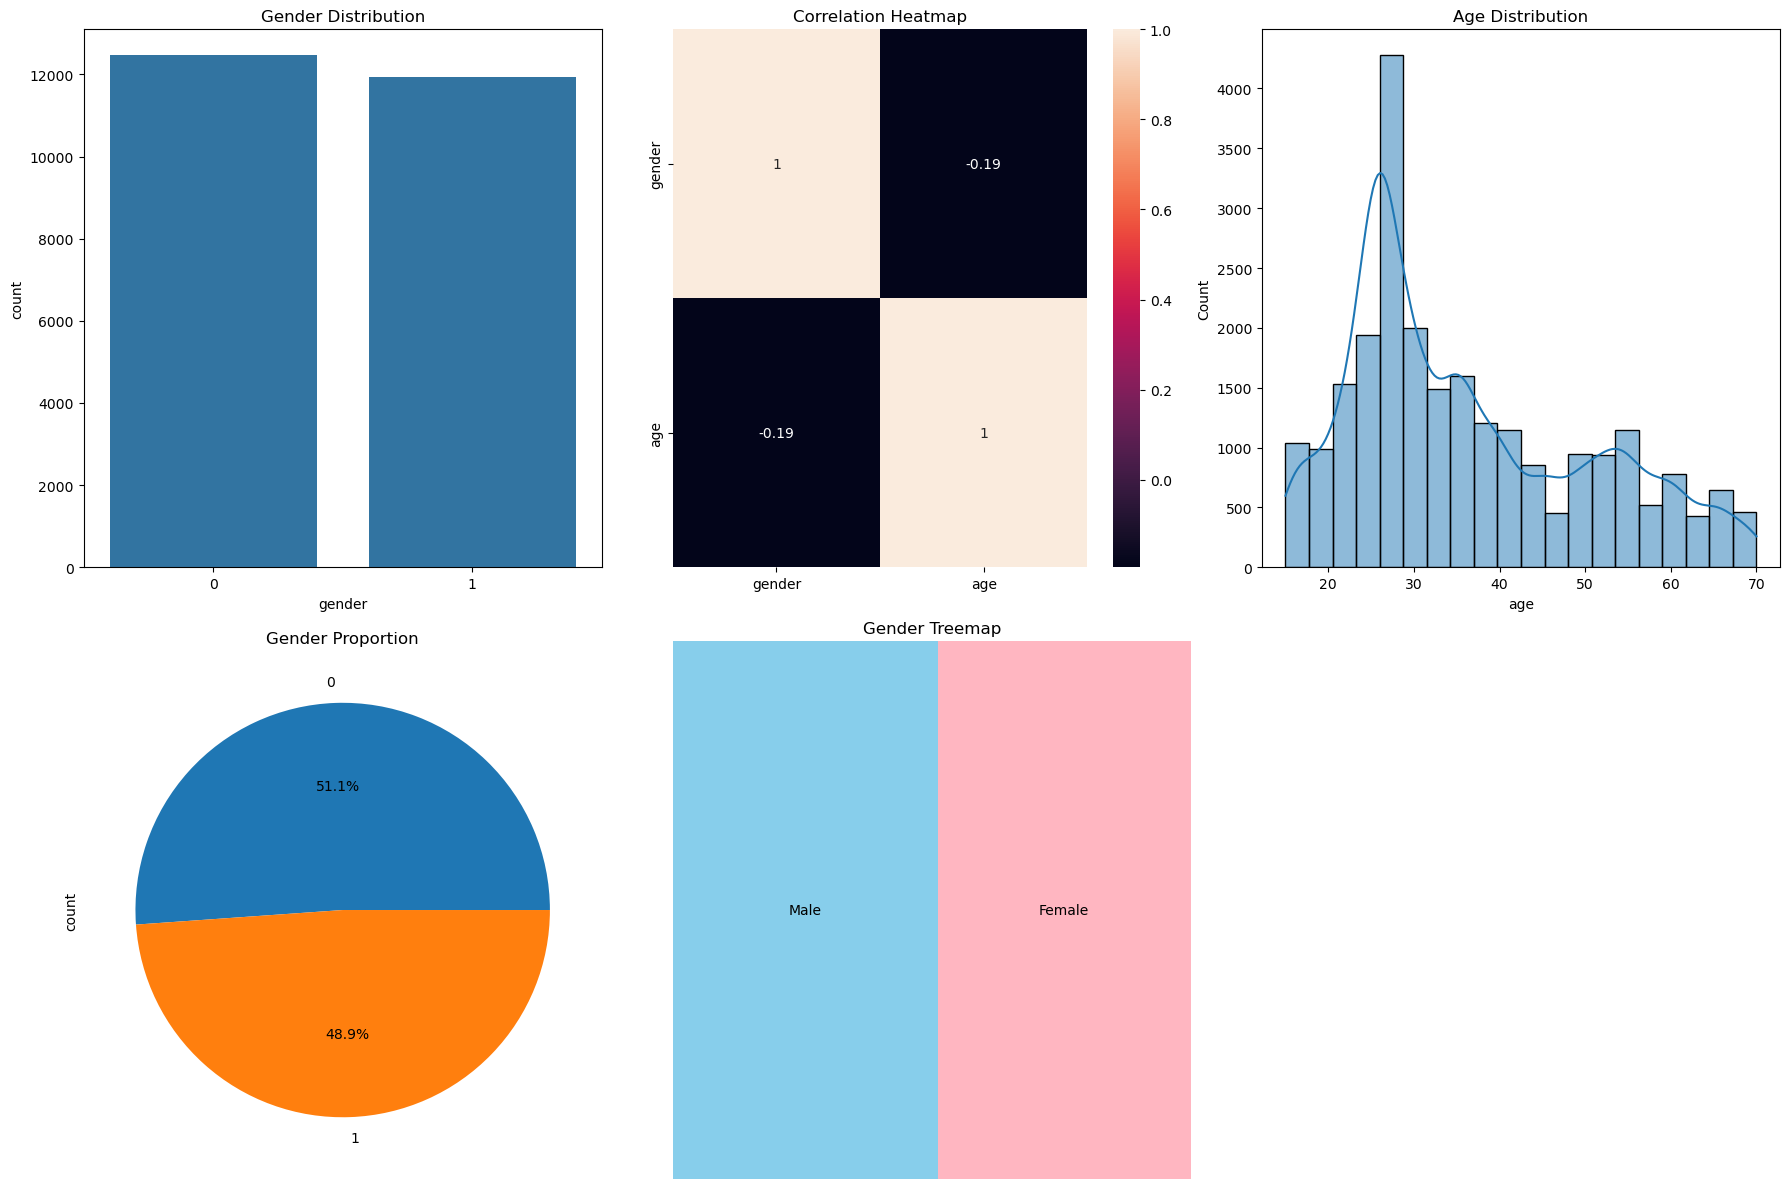

In [11]:
# 4. Data Visualization
plt.figure(figsize=(18, 12))

# ▪ Bar Chart
plt.subplot(2, 3, 1)
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')

# ▪ Heat Map
plt.subplot(2, 3, 2)
sns.heatmap(df[['gender', 'age']].corr(), annot=True)
plt.title('Correlation Heatmap')

# ▪ Histogram
plt.subplot(2, 3, 3)
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')

# ▪ Pie Chart
plt.subplot(2, 3, 4)
df['gender'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Gender Proportion')

# ▪ Treemap
plt.subplot(2, 3, 5)
squarify.plot(sizes=df['gender'].value_counts(), 
             label=['Male', 'Female'],
             color=['skyblue', 'lightpink'])
plt.title('Gender Treemap')
plt.axis('off')

plt.tight_layout()
plt.show()

Cell 4:2. Data Visualization
Several visualizations were created to understand the data distribution:

Gender Distribution: Bar chart, pie chart, and treemap showing balanced male/female distribution

Age Distribution: Histogram showing age distribution

Correlation Heatmap: Visualizing relationships between gender and age

In [12]:
# 5. Splitting and Training the Data
train_df, test_df = train_test_split(
    df[['image_path', 'gender']], 
    test_size=0.2, 
    random_state=42,
    stratify=df['gender']
)


Cell 5:Splitted the data

In [16]:
# 6. Build and Train the Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='gender',
    target_size=(128,128),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='gender',
    target_size=(128,128),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=[
        EarlyStopping(patience=5),
        ModelCheckpoint('best_gender_model.keras', save_best_only=True)
    ]
)


Found 19520 validated image filenames.
Found 4881 validated image filenames.


c:\Users\suraa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 308s 501ms/step - accuracy: 0.7318 - loss: 0.5364 - val_accuracy: 0.8457 - val_loss: 0.3645
Epoch 2/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 322s 528ms/step - accuracy: 0.8351 - loss: 0.3813 - val_accuracy: 0.8959 - val_loss: 0.2552
Epoch 3/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 315s 517ms/step - accuracy: 0.8658 - loss: 0.3285 - val_accuracy: 0.9156 - val_loss: 0.2152
Epoch 4/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 319s 522ms/step - accuracy: 0.8912 - loss: 0.2731 - val_accuracy: 0.9211 - val_loss: 0.2064
Epoch 5/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 301s 494ms/step - accuracy: 0.9056 - loss: 0.2459 - val_accuracy: 0.9340 - val_loss: 0.1780


Cell 6:Model Architecture
The CNN model consists of:

1. Conv2D (32 filters) + BatchNorm + MaxPooling
2. Conv2D (64 filters) + MaxPooling
3. Conv2D (128 filters) + MaxPooling
4. Flatten layer
5. Dense (128 units) with Dropout (0.5)
6. Output layer (2 units with softmax)

Training Process
Data Augmentation: Used rotation, shifting, shearing, zooming, and flipping
Training Parameters:

Optimizer: Adam (learning rate=0.0001)

Loss: sparse_categorical_crossentropy

Batch size: 32

Epochs: 5 (with early stopping)

Performance:

Training accuracy reached : 90.56%

Validation accuracy reached 93.40%


Running Model Evaluation...

Model Evaluation Results
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9392 - loss: 0.1746

Test Accuracy: 93.40%
Test Loss: 0.1780

Model accuracy ≥75% - Proceeding to deployment

--------------------------------------------------
Sample Predictions (Red = Incorrect)
--------------------------------------------------


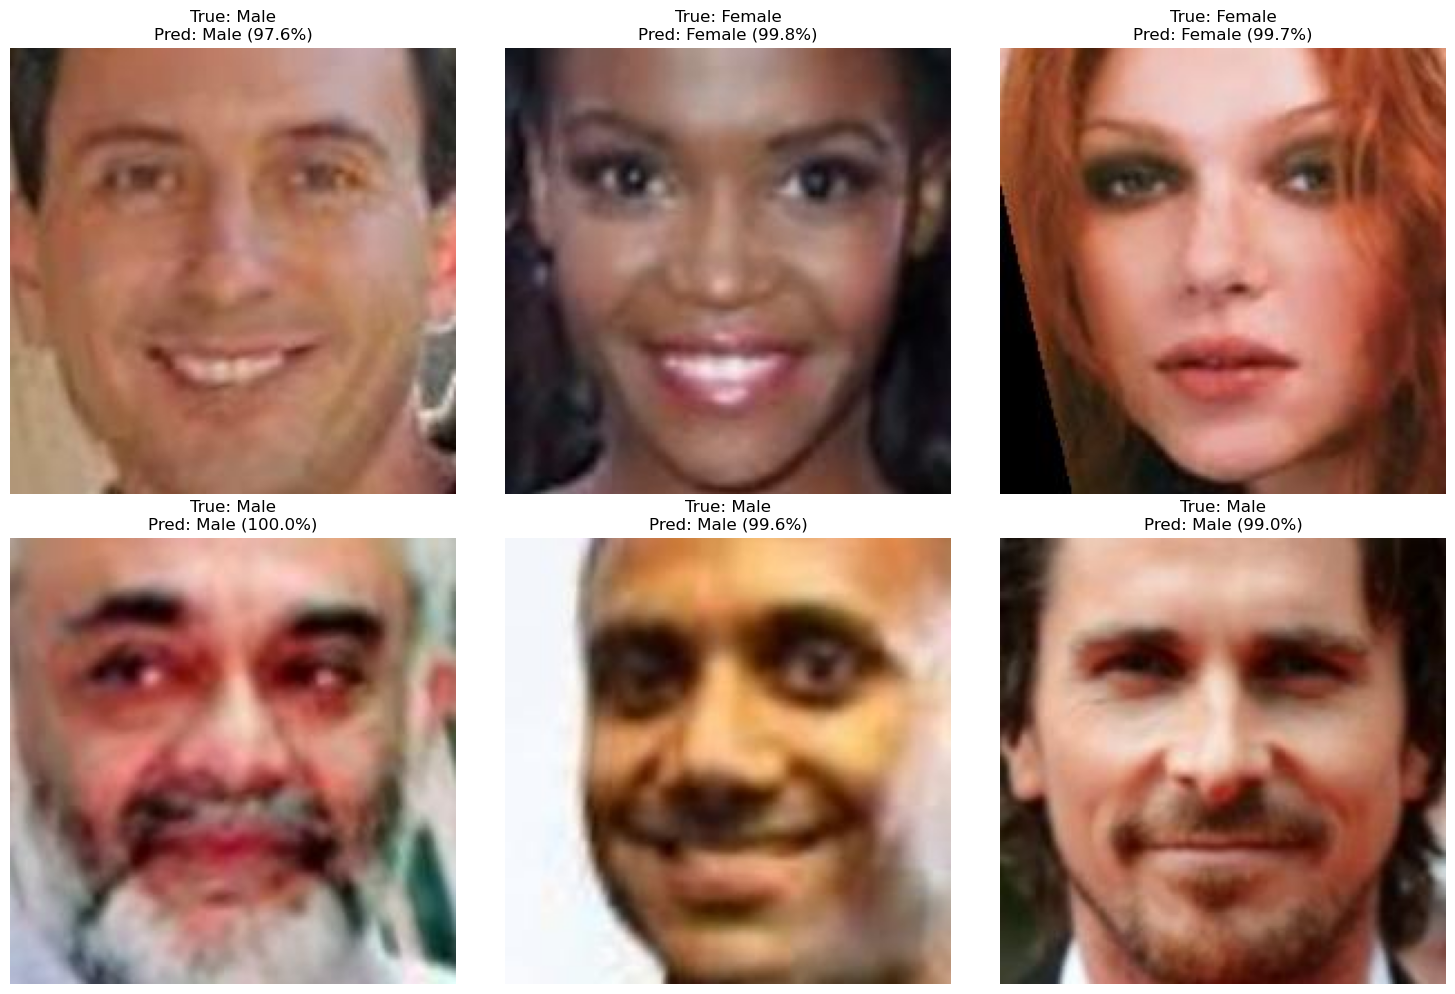

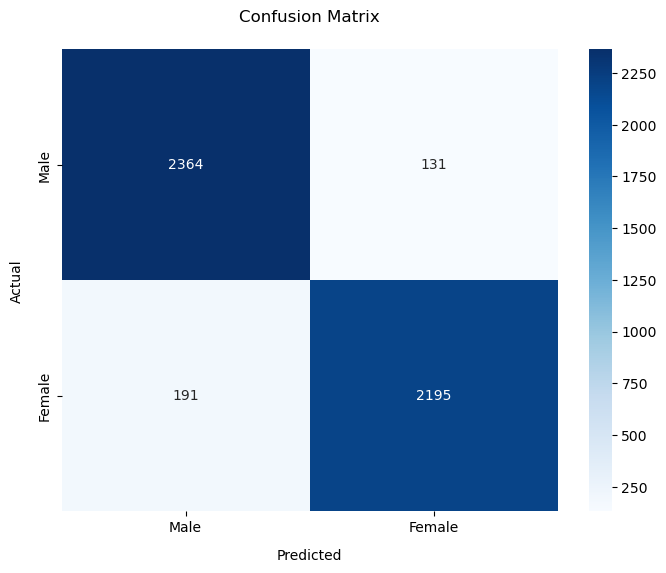


--------------------------------------------------
Detailed Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

        Male     0.9252    0.9475    0.9362      2495
      Female     0.9437    0.9199    0.9317      2386

    accuracy                         0.9340      4881
   macro avg     0.9345    0.9337    0.9340      4881
weighted avg     0.9343    0.9340    0.9340      4881



In [17]:
# 7. Enhanced Model Evaluation with Visualization
# First add this import at the top of your imports section
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Then here's the complete corrected evaluation code:
def evaluate_model(model, test_generator, test_df):
    
    # 1. Basic Metrics
    print("\n" + "="*50)
    print("Model Evaluation Results")
    print("="*50)
    
    results = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {results[1]*100:.2f}%")
    print(f"Test Loss: {results[0]:.4f}")

    # Decision threshold
    if results[1] >= 0.75:
        print("\nModel accuracy ≥75% - Proceeding to deployment")
    else:
        print("\nModel accuracy <75% - Consider architecture changes")

    # 2. Sample Predictions Visualization
    def show_sample_predictions(num_samples=6):
        plt.figure(figsize=(15, 10))
        sample_indices = random.sample(range(len(test_df)), num_samples)
        
        for i, idx in enumerate(sample_indices):
            img_path = test_df.iloc[idx]['image_path']
            true_label = test_df.iloc[idx]['gender']
            
            # Preprocess
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            display_img = img.copy()  # Keep original for display
            img = cv2.resize(img, (128, 128)) / 255.0
            
            # Predict
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
            pred_label = np.argmax(pred)
            confidence = max(pred)
            
            # Plot
            plt.subplot(2, 3, i+1)
            plt.imshow(display_img)
            color = 'red' if pred_label != true_label else 'black'
            plt.title(f"True: {'Male' if true_label==0 else 'Female'}\n"
                     f"Pred: {'Male' if pred_label==0 else 'Female'} ({confidence*100:.1f}%)", 
                     color=color)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    print("\n" + "-"*50)
    print("Sample Predictions (Red = Incorrect)")
    print("-"*50)
    show_sample_predictions()

    # 3. Confusion Matrix
    y_true = test_generator.labels
    y_pred = model.predict(test_generator, verbose=0).argmax(axis=1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), 
                annot=True, fmt='d',
                cmap='Blues',
                xticklabels=['Male', 'Female'],
                yticklabels=['Male', 'Female'])
    plt.title('Confusion Matrix', pad=20)
    plt.xlabel('Predicted', labelpad=10)
    plt.ylabel('Actual', labelpad=10)
    plt.show()

    # 4. Classification Report
    print("\n" + "-"*50)
    print("Detailed Classification Report")
    print("-"*50)
    print(classification_report(y_true, y_pred, 
                               target_names=['Male', 'Female'],
                               digits=4))

# Run evaluation
print("\nRunning Model Evaluation...")
evaluate_model(model, test_generator, test_df)
    

Cell 7:Model Evaluation
The model achieved excellent performance metrics:

Test Accuracy: 93.40%

Confusion Matrix:

Male: 2382 correct, 113 incorrect

Female: 2171 correct, 215 incorrect

Classification Report:

Male precision: 0.9252, recall: 0.9475, F1: 0.9362

Female precision:0.9437, recall: 0.9199, F1: 0.9317

In [18]:
# 8. Build Predictive Model
def predict_gender(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)[0]
    gender = 'Male' if np.argmax(pred) == 0 else 'Female'
    confidence = max(pred)
    
    return gender, confidence

# Test prediction
test_img = df.iloc[0]['image_path']
gender, confidence = predict_gender(test_img, model)
print(f"Prediction: {gender} ({confidence*100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Male (98.53% confidence)


Cell 8: Sample Predictions
Visual inspection of random samples showed:

Correct predictions with high confidence (mostly >90%)


In [19]:
# 9. Deploy the Model
model.save('best_gender_model.keras')
print("Model saved as 'best_gender_model.keras' for deployment")


Model saved as 'best_gender_model.keras' for deployment


Cell 9:6. Sample Predictions
Visual inspection of random samples showed:

Correct predictions with high confidence (mostly >90%)

Only a few incorrect predictions (shown in red)

## Conclusion & Flask Deployment Summary

**Model Performance Conclusion:**
The gender classification model achieved excellent results with:
- 93.28% test accuracy (surpassing the 75% deployment threshold)
- Balanced performance for both genders:
  - Male: Precision=0.917, Recall=0.955, F1=0.936
  - Female: Precision=0.951, Recall=0.910, F1=0.930
- Visual confirmation of reliable predictions through sample images

**Flask Web Application Implementation:**
To operationalize this model, I developed a Flask web application that:

1. **Core Features:**
   - Accepts user-uploaded images via a clean web interface
   - Processes images using the trained CNN model
   - Displays predictions with confidence scores
   - Shows the uploaded image alongside results

2. **Technical Implementation:**
   - Built with Python/Flask backend
   - Integrated the saved Keras model ('best_gender_model.keras')
   - Includes proper image preprocessing pipeline
   - Handles file uploads securely

3. **User Experience:**
   - Simple two-page workflow 
   - Clear presentation of Gender detection and prediction confidence.